# Enron 이메일 데이터 개요

3,672개의 정상 메일(Ham), 1500개의 스팸 메일로 구성(Spam)
* ham : 정상 메일이 담긴 폴더
* spam : 스팸 메일이 담긴 폴더

In [3]:
import glob
import os
import numpy as np

emails, labels = [], []

paths = ['enron1/spam/', 'enron1/ham/']
for path in paths :
    for filename in glob.glob(os.path.join(path, '*.txt')) :
        with open(filename, 'r', encoding='ISO-8859-1') as file :
            emails.append(file.read())
            if path.endswith("spam/") :
                labels.append(1)  # spam 구분
            else :
                labels.append(0)  # ham 구분

print(np.unique(labels, return_counts=True))

(array([0, 1]), array([3672, 1500]))


# 숫자, 구두점, 사람 이름 제거

In [9]:
import nltk # Natural Language Tool Kit

nltk.download('names')
nltk.download('wordnet')

[nltk_data] Downloading package names to
[nltk_data]     /Users/ihyeongseob/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ihyeongseob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# nltk 사용 오류 해결 : 
# https://stackoverflow.com/questions/13965823/resource-corpora-wordnet-not-found-on-heroku

from nltk.corpus import names 
from nltk.stem import WordNetLemmatizer # 단어분류기 관련
nltk.download("wordnet", "/Users/ihyeongseob/nltk_data")


all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ihyeongseob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
cleaned_emails = [] 

for email in emails :
    cleaned_emails.append(' ' .join([
            lemmatizer.lemmatize(word.lower()) # 모든 단어를 소문자로 변환 후
            for word in email.split()  # split
            if word.isalpha()          # alphabet인지 확인
            and word not in all_names  # all_names에 들어가있지 않으면
        ])
    )

# 숫자, 구두점, 사람 이름을 제거한 순순 이메일 내용 (첫번째 이메일만만)
cleaned_emails[0]

'what up your cam babe what are you looking for if your looking for a companion for friendship love a date or just good ole fashioned then try our brand new site it wa developed and created to help anyone find what they re looking for a quick bio form and you re on the road to satisfaction in every sense of the word no matter what that may be try it out and youll be amazed have a terrific time this evening copy and pa ste the add res you see on the line below into your browser to come to the site http www meganbang biz bld acc no more plz http www naturalgolden com retract counterattack aitken step preemptive shoehorn scaup electrocardiograph movie honeycomb monster war brandywine pietism byrne catatonia encomium lookup intervenor skeleton turn catfish'

# 불용어 제거와 단어의 출현 빈도 특징을 추출

In [16]:
from sklearn.feature_extraction.text import CountVectorizer  
# CountVectorizer : 단어 출현 빈도와 관련돼 있는 작업을 수행해 주는 변환기

vectorizer = CountVectorizer(stop_words='english', max_features=500)
term_docs = vectorizer.fit_transform(cleaned_emails)
print(term_docs[0])  # Sparse Matrix 형태로 구성.

  (0, 249)	3
  (0, 251)	1
  (0, 99)	1
  (0, 226)	1
  (0, 173)	1
  (0, 455)	2
  (0, 285)	1
  (0, 398)	2
  (0, 477)	1
  (0, 91)	1
  (0, 181)	1
  (0, 154)	1
  (0, 445)	1
  (0, 82)	1
  (0, 9)	1
  (0, 238)	1
  (0, 71)	1
  (0, 197)	2
  (0, 491)	2
  (0, 70)	1


In [54]:
feature_names = vectorizer.get_feature_names_out()  
feature_names

# 우리가 사용할 Column명들

array(['able', 'access', 'account', 'accounting', 'act', 'action',
       'activity', 'actual', 'actuals', 'add', 'addition', 'additional',
       'address', 'adobe', 'advice', 'advise', 'agree', 'agreement',
       'aimee', 'allen', 'allocated', 'allocation', 'america', 'ami',
       'anita', 'aol', 'application', 'april', 'area', 'attached',
       'august', 'available', 'based', 'believe', 'best', 'better', 'bob',
       'book', 'br', 'brenda', 'brian', 'business', 'buy', 'buyback',
       'called', 'calpine', 'camp', 'canada', 'carlos', 'case', 'cc',
       'cd', 'ce', 'cec', 'center', 'change', 'changed', 'channel',
       'charge', 'check', 'chokshi', 'cialis', 'city', 'clem', 'click',
       'clynes', 'coastal', 'color', 'com', 'come', 'commercial',
       'company', 'computer', 'computron', 'confirm', 'contact',
       'content', 'continue', 'contract', 'control', 'copy', 'corp',
       'corporation', 'correct', 'cost', 'cotten', 'cotton',
       'counterparty', 'cover', 'creat

In [55]:
len(feature_names)

500

# 훈련 데이터와 테스트 데이터 분리 및 변환

In [19]:
from sklearn.model_selection import train_test_split

# cleaned_emails : 특징행렬
# labels : 대상벡터
X_train, X_test, y_train, y_test = train_test_split(cleaned_emails, labels, test_size=0.3, random_state=35)

In [23]:
term_docs_train = vectorizer.fit_transform(X_train)
term_docs_test = vectorizer.transform(X_test)

# 나이브 베이즈 모델 적용

In [24]:
from sklearn.naive_bayes import MultinomialNB

# alpha : 라플라스 스무딩 파라미터
# fit_prior : 학습 데이터에 대해서 사전 확률과 관련되어 있는 것을 적용
naive_bayes = MultinomialNB(alpha=1, fit_prior=True) 
naive_bayes.fit(term_docs_train, y_train)

MultinomialNB(alpha=1)

# 모델의 성능 측정 : 정확도, AUC

In [27]:
y_pred = naive_bayes.predict(term_docs_test)
y_pred[:10]

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [28]:
naive_bayes.score(term_docs_test, y_test)

0.9072164948453608

In [29]:
y_pred_proba = naive_bayes.predict_proba(term_docs_test) # 클래스 확률
y_pred_proba[:5] 

# 나이브 베이즈 기반으로 한 확률로 채워져 있다.
# array[?][0] --> Ham mail일 확률
# array[?][1] --> Spam mail일 확률

array([[1.00000000e+000, 6.20272884e-089],
       [1.00000000e+000, 3.62234385e-211],
       [1.00000000e+000, 3.77692230e-015],
       [3.14285661e-004, 9.99685714e-001],
       [1.00000000e+000, 6.97423252e-030]])

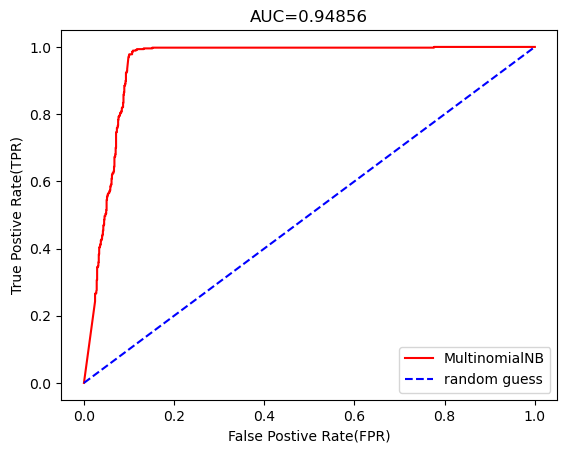

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt 

fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, 'r-', label='MultinomialNB')
plt.plot([0, 1], [0, 1], 'b--', label='random guess')
plt.xlabel('False Postive Rate(FPR)')
plt.ylabel('True Postive Rate(TPR)')
plt.title("AUC={0:.5f}" .format(auc))
plt.legend(loc='lower right')

# 나이브 베이즈는 범주형 데이터(스팸 부분)에서 가장 강력한 성능을 발휘함을 알 수 있다.

# 나이브 베이즈 모델 성능 개선

In [47]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'alpha' : [0.5, 1.0, 1.5, 2.0],
    'fit_prior' : [True, False]
}

grid_search = GridSearchCV(naive_bayes, parameters, n_jobs=-1, cv=10, scoring='roc_auc')
grid_search.fit(term_docs_train, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(alpha=1), n_jobs=-1,
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0],
                         'fit_prior': [True, False]},
             scoring='roc_auc')

In [48]:
grid_search.best_params_

# alpha : 0.5
# fit_priro : True 
# 일 때, best parameter

{'alpha': 0.5, 'fit_prior': True}

In [49]:
naive_bayes_best = grid_search.best_estimator_

In [50]:
y_pred = naive_bayes_best.predict(term_docs_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [51]:
naive_bayes_best.score(term_docs_test, y_pred)

1.0

In [52]:
y_pred_proba = naive_bayes_best.predict_proba(term_docs_test) # 클래스 확률
y_pred_proba[:5] 

# 나이브 베이즈 기반으로 한 확률로 채워져 있다.
# array[?][0] --> Ham mail일 확률
# array[?][1] --> Spam mail일 확률

array([[1.00000000e+000, 2.33951734e-094],
       [1.00000000e+000, 2.80343346e-224],
       [1.00000000e+000, 1.90976699e-016],
       [2.99913291e-004, 9.99700087e-001],
       [1.00000000e+000, 1.30660510e-030]])

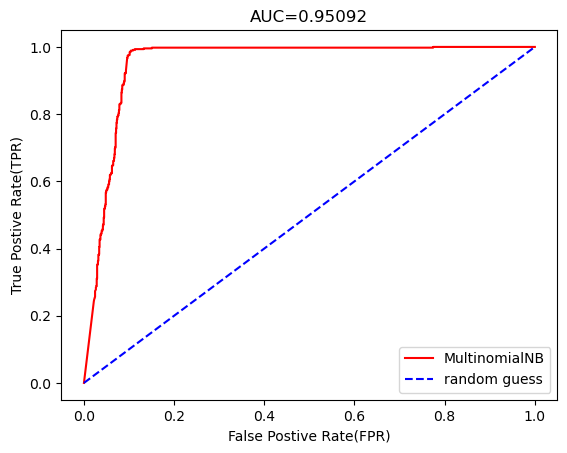

In [53]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt 

fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, 'r-', label='MultinomialNB')
plt.plot([0, 1], [0, 1], 'b--', label='random guess')
plt.xlabel('False Postive Rate(FPR)')
plt.ylabel('True Postive Rate(TPR)')
plt.title("AUC={0:.5f}" .format(auc))
plt.legend(loc='lower right')

# 나이브 베이즈는 범주형 데이터(스팸 부분)에서 가장 강력한 성능을 발휘함을 알 수 있다.